In [4]:
# Dylan Kearney - 18227023, Cyiaph McCann - 17233453
# The code executes to the end without an error.
# Data pre-processing guide: https://medium.com/geekculture/stroke-prediction-d26c15f9d1
# Keras classification guide: https://www.bmc.com/blogs/keras-neural-network-classification/

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# Dataset

In [6]:
strokeData = pd.read_csv("healthcare-dataset-stroke-data.csv")

Investigate the data.

The dataset has rich features, and 5110 rows. This seems sufficiently large.
We noticed that the count is 5110 for all the columns except for BMI, 
therefore there must be some missing values.

In [7]:
strokeData.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


We investigated the data types and if the columns have null values or not

In [8]:
strokeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Visualisation
We wanted to visualise the correlation of the data; 
try see which variables might indicate a the likelyhood stroke

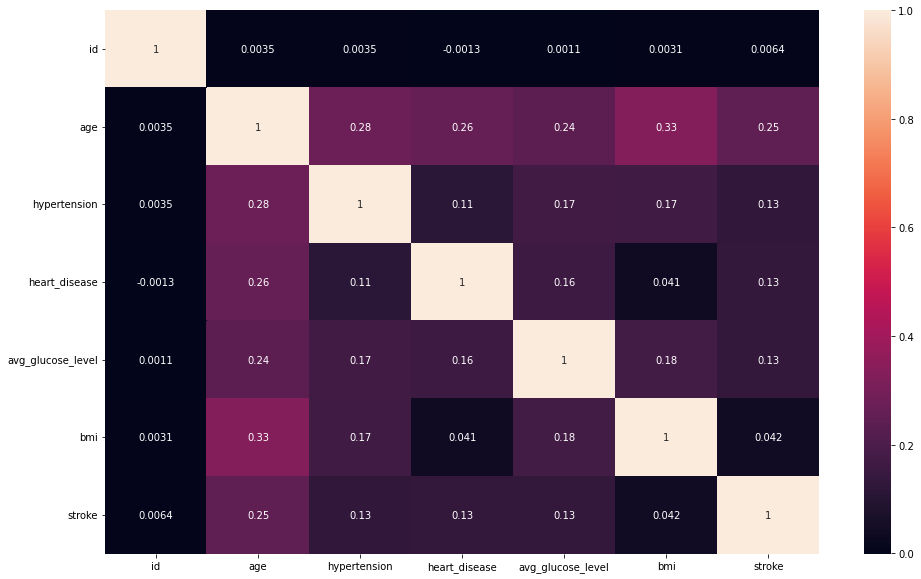

In [9]:
plt.figure(figsize=(16,10))
sns.heatmap(strokeData.corr(method='pearson'), annot=True)

We wanted to compare the distribution of ages in the dataset. We are happy with the distribution as it seems quite even across the historgram.

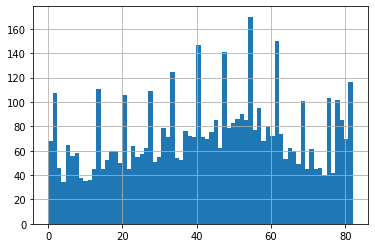

In [10]:
strokeData['age'].hist(bins=70)

We noticed that there might be a good correlation between age and having a stroke.
The scatter plot below confirms our suspicion as it shows strokes are more common above the age of 40 and only a few occur under the age of 40.

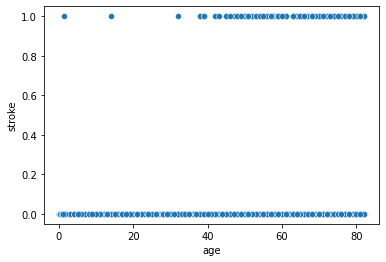

In [11]:
sns.scatterplot(x=strokeData['age'], y=strokeData['stroke'])

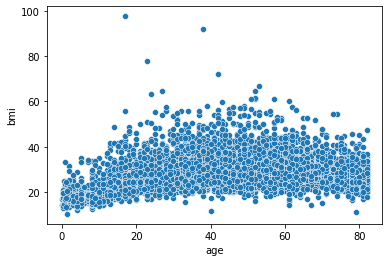

In [12]:
sns.scatterplot(x=strokeData['age'], y=strokeData['bmi'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


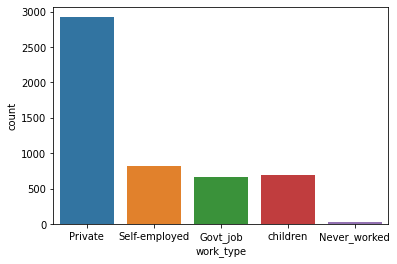

In [13]:
sns.countplot(strokeData['work_type'])

Next we compare the number of strokes with number of people that had no strokes.

We see there is a big imbalance in the data and this must be solved before performing the MLP

In [14]:
strokeData['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


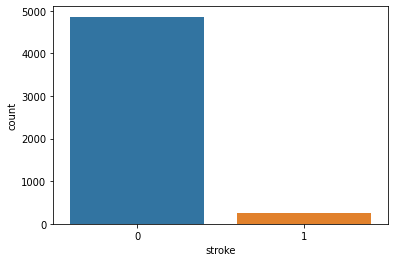

In [15]:
sns.countplot(strokeData['stroke'])

### Data-preprocessing

Here we count how many missing values are in the columns 

In [16]:
strokeData.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Replace missing values in BMI column with the value of mean of BMI

In [17]:
strokeData['bmi'] = strokeData['bmi'].fillna(strokeData['bmi'].mean())

Drop ID column as it does not have meaningful information. The row number works as a unique identifier

In [18]:
strokeData = strokeData.drop(columns = 'id')

Next we count how many of each gender there is in the set

In [19]:
strokeData['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

We noticed there is just one gender "Other" so we replace it so that it doesn't skew the data

In [20]:
strokeData['gender'] = strokeData['gender'].replace('Other', list(strokeData.gender.mode().values)[0])
strokeData.gender.value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

Here we encode the data to numbers so that the model can interpret it. For example, gender becomes zero and one instead of male and female.

In [21]:
obtype=['gender','ever_married','work_type','Residence_type','smoking_status']
gen_encode=LabelEncoder()
mar_encode=LabelEncoder()
work_encode=LabelEncoder()
res_encode=LabelEncoder()
smo_encode=LabelEncoder()
strokeData['gender'] = gen_encode.fit_transform(
    strokeData['gender'])
strokeData['ever_married'] = mar_encode.fit_transform(
    strokeData['ever_married'])
strokeData['work_type'] = work_encode.fit_transform(
    strokeData['work_type'])
strokeData['Residence_type'] = res_encode.fit_transform(
    strokeData['Residence_type'])
strokeData['smoking_status'] = smo_encode.fit_transform(
    strokeData['smoking_status'])


Next we investigate what the data looks like now that the data is encoded and preprocessed.

In [22]:
strokeData.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1


# Preparing Test and Train sets


We prepare the test and train data sets.

'labels' is the stroke column. np.ravel converts it to an array

'strokeCol' is the column that is either 0 indicating the person had no stroke or 1 to indicate the person had a stroke


In [23]:
strokeCol = strokeData['stroke']
X = strokeData.iloc[:, 0:10]

y = np.ravel(strokeCol)

Here we solve the imbalances of the data; i.e. stroke column

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



test_size is 30% of overall dataset and is used to test accuracy of the model, random_state is set to 42

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, 
                                                    y_smote,
                                                    test_size=0.30, 
                                                    random_state=42) 

**Normalize** the data sets using the sklearn libraries StandardScaler function

This means for each value in the training and test data set and calculate the distance from the mean divided by the standard deviation.

This puts the data on a standard scale.

In [26]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# copy over the train and test sets for later use
X_train_valid = X_train
X_test_valid = X_test
y_train_valid = y_train
y_test_valid = y_test

# Network

We create the Keras model by adding layers.
We chose the Sequential model because we want a feed-forward traditional MLP network.

We picked the activation function for each layer

We chose Sigmoid as the activation function on the output layer as this is the common choice for binary classification problems.

In [27]:
model = Sequential()

model.add(Dense(50, activation='softmax', 
                input_shape=(10,), 
                kernel_initializer='he_normal'))
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

**Loss function** 

We first decided that **binary_crossentropy** is the best choice as the stroke outcome is binary (0 or 1). But we later found out that MSE is also applicable and gives us a lower loss function.


We tried using categorical_crossentropy and sparse_categorical_crossentropy but these did not perform well on the data.

**Optimizer**

optimizer is '**adam**' in order to attempt to minimize the loss function as fast as possible. This gave us the best accuracy and the least loss. *See below where we made a comparison between the optimizers.*

**Metrics**

We want to see the accuracy of the model as it runs.

**Fitting/Training the model**

Epochs sets the number of iterations of the model. We chose 50 epochs after some testing to get the best result without overfitting. We wanted to refine this however so we employed the EarlyStopper callback function from keras to stop fitting the model when the loss doesnt decrease enough from epoch to epoch. 

Batch size splits the data into batches and processes them in parallel. We set this to 16 as we got the best results with this.

Verbose is boolean and logs the output so we set verbose to **true**.

We set the validation_split to 0.2. This is using an automatic validation dataset on our binary classification.

Shuffle will shuffle X_train, y_train. We don't shuffle the data as thw row number is our unique identifier for the rows and this is important for later on in the results section.


In [28]:
optimizer = Adam(learning_rate=0.04)
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['accuracy'])

EPOCHS = 50
BATCH_SIZE = 16
VERBOSE = 1

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

history = model.fit(X_train, y_train,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=VERBOSE, 
          validation_split=0.20,
          shuffle=False,
          callbacks=[es])

Epoch 1/50
341/341 [==============================] - 2s 2ms/step - loss: 0.1501 - accuracy: 0.7888 - val_loss: 0.1449 - val_accuracy: 0.8046
Epoch 2/50
341/341 [==============================] - 1s 2ms/step - loss: 0.1327 - accuracy: 0.8178 - val_loss: 0.1242 - val_accuracy: 0.8310
Epoch 3/50
341/341 [==============================] - 1s 2ms/step - loss: 0.1212 - accuracy: 0.8349 - val_loss: 0.1280 - val_accuracy: 0.8251
Epoch 4/50
341/341 [==============================] - 1s 2ms/step - loss: 0.1160 - accuracy: 0.8417 - val_loss: 0.1189 - val_accuracy: 0.8464
Epoch 5/50
341/341 [==============================] - 1s 2ms/step - loss: 0.1116 - accuracy: 0.8503 - val_loss: 0.1173 - val_accuracy: 0.8428
Epoch 6/50
341/341 [==============================] - 1s 2ms/step - loss: 0.1056 - accuracy: 0.8551 - val_loss: 0.1017 - val_accuracy: 0.8692
Epoch 7/50
341/341 [==============================] - 1s 2ms/step - loss: 0.1041 - accuracy: 0.8565 - val_loss: 0.1080 - val_accuracy: 0.8626
Epoch 

Now we print a summary of the model to visualize the shape of the layers 

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


# Results

Here we consider the results. 

Since we used a sigmoid activation function on the output layer of the sequential model and the does binary classification, we know that the threshold is 0.5. Therefore, 
we know that if the prediction value is > 0.5 then the model is predicting that based off the features, that person is likey to have a stroke.


'y_pred' is an array containing the predictions from the 
model based on the test set.

In [30]:
y_pred = model.predict(X_test)

predictionsDF = pd.DataFrame(y_pred, columns=['prediction'])

predictedStrokes = []
for pred in (y_pred) :
  if(pred > 0.5):
    predictedStrokes.append(1)
  else:
    predictedStrokes.append(0)

predictionsDF['predicted'] = (predictedStrokes)
predictionsDF['actual'] = (y_test)

predictionsDF.head(10)

,prediction,predicted,actual
0,2.273762e-08,0,0
1,4.299993e-01,0,1
2,1.296933e-01,0,0
3,2.353342e-08,0,0
4,9.161654e-01,1,1
5,7.203019e-01,1,1
6,9.436025e-05,0,0
7,6.305348e-01,1,0
8,9.991952e-01,1,1
9,6.305348e-01,1,0


Here we count how many predictions the model got right.

We can see from this how much it got right and wrong.

In [31]:
comparison_column = np.where(
    predictionsDF["predicted"] == predictionsDF["actual"], True, False)
predictionsDF['predicted_correctly'] = comparison_column
predictionsDF['predicted_correctly'].value_counts()

True     2566
False     351
Name: predicted_correctly, dtype: int64

Next we plot how the accuracy changed over the Epochs on both the train and test data.

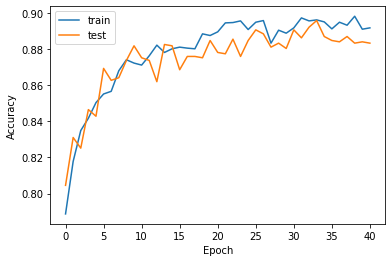

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Next we plot how the loss changed over the Epochs.

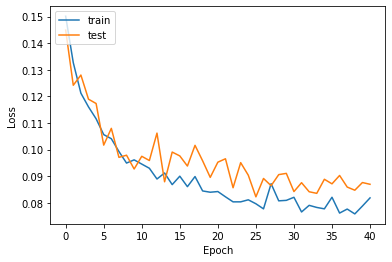

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Here we calculate metrics precision, recall and F1 score.

In [34]:
from sklearn.metrics import precision_score, f1_score, recall_score

precision = precision_score(y_test, predictedStrokes)
print('Precision: %f' % precision)

recall = recall_score(y_test, predictedStrokes)
print('Recall: %f' % recall)

f1 = f1_score(y_test, predictedStrokes)
print('F1 score: %f' % f1)

Precision: 0.868439
Recall: 0.895205
F1 score: 0.881619


# Evaluation

Evaluate the model on the test set

Tracking Results with different hyper params:

**Loss Function**
1. Binary_crossentropy: 89% accuracy, 25% loss
2. MSE: 89% accuracy, 8% loss

We decided to chose MSE as to estimate the loss of the model so that the weights can be changed to reduce the loss.

**Optimizers**:

1. adam -> ~86.5% accuracy, 28% loss
2. SGD -> ~77.6% accuracy and 47% loss
3. RMSProp -> ~86.6% accuracy, 31% loss
4. adamax -> 82% accuracy, 40% loss

We decided to pick the one with the least loss.

**Epochs**

Next we looked at the number of Epochs to try to figure out where the sweet spot is between underfitting and overfitting

We discovered that at about Epoch 50 the accuracy and loss begins to improve at a much slower rate. Therefore we decided to choose to do 40 Epochs.

**Batch Size**

We increased the batch size and quickly noticed the accuracy reducing. Therefore we decided on a batch size of 16 in order to speed up computation while maintaining good accuracy.

In [35]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("\n-- ACCURACY OF MODEL ON TEST SET --")
print("Accuracy: ", test_accuracy[1]*100, "%")
print("Loss: ", test_accuracy[0]*100, "%")


-- ACCURACY OF MODEL ON TEST SET --
Accuracy:  87.96709179878235 %
Loss:  8.91234427690506 %


**Check for overfitting and underfitting**

A model is thought to be overfitting if your validation loss has been increasing and underfit is the validation loss is still decreasing.

While we did use the EarlyStopper to chose a good stopping point for the model, we wanted to confirm our choice by doing a big number of Epochs and visualising where the best point in the curve is.


Here we will make a similar MLP model but this time it will have extra epochs so that we can visualize where underfitting and overfitting is. From this we can see that our choice of about 50 epochs seems efficient.

In [36]:
temp_model = Sequential()

temp_model.add(Dense(50, activation='softmax', 
                input_shape=(10,), 
                kernel_initializer='he_normal'))
temp_model.add(Dense(30, activation='relu'))
temp_model.add(Dense(1, activation='sigmoid'))

temp_optimizer = Adam(learning_rate=0.04)
temp_model.compile(loss='mse',
              optimizer=temp_optimizer)

bigHistory = temp_model.fit(X_train, y_train,
          epochs=150, 
          batch_size=BATCH_SIZE, 
          verbose=0, 
          validation_split=0.20,
          shuffle=False)


Plot the validation set loss over the epochs

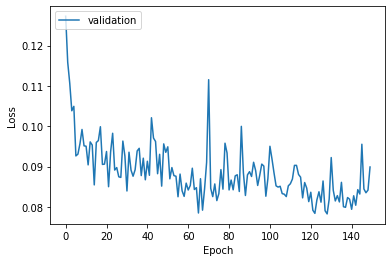

In [37]:
plt.plot(bigHistory.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['validation'], loc='upper left')
plt.show()

From this it seems that maybe about 40-50 Epochs will give the best result. The curve seems to level out from there on. 

# Experimentations

1. We experimented with changing the size of the test set data from 0.3 to 0.2 and we found that the accuracy went down as the model was overfitting on the training data.

2. At first we made the model with just one hidden layer and as a result we got a loss of ~ 50%. This indicated the model was underfitting.

3. By adding another layer, we got the loss down to ~40% and improved the accuracy by 10%

4. We tried different numbers of neurons on the layers and found that the current implementation was best.

5. We attempted a linear regression on the data as at the start we were thinking the data might be linearly classifiable. We were incorrect. (See below)

#### Linear Regression

Here we attempt to apply the LinearRegression model to the data set to see if the data is linearly predictable.

We got about 9% accuracy with this model so we decided that this is not a good choice.

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

strokeCol = strokeData['stroke']
X = strokeData.iloc[:, 0:10]

y = np.ravel(strokeCol)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.20, 
                                                    random_state=42) 

regr = LinearRegression()

# Train the model using the train sets
regr.fit(X_train, y_train)

# Make predictions using the test set
y_pred_linear = regr.predict(X_test)

regr.score(X_test, y_test)

0.09360992204574692

# Findings

1. Increasing the batch size reduces the computation time of the MLP
2. Since we are dealing with a binary classification problem, we chose to either do binary_crossentropy or MSE. If we use one such as categorical_crossentropy or sparse_categorical_crossentropy they cause the model to behave strangely. 
3. We were getting 0.953 accuracy without fail even with just one layer on the MLP but what was happening was just that there was a huge imbalance in the data on the stroke column. There was only a few hundred data rows with strokes and the rest had no stroke so we needed to employ a SMOTE to refit the data to try and balance the data.
4. Towards the end of this 2 week project, we tried out the MSE loss function and we reduced the loss from about 25% to 9%. 